In [1]:
import pandas as pd
#read the data
data = pd.read_csv('MSFT-2.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-16,62.950001,62.950001,62.119999,62.299999,57.387455,42453100
1,2016-12-19,62.560001,63.770000,62.419998,63.619999,58.603355,34338200
2,2016-12-20,63.689999,63.799999,63.029999,63.540001,58.529682,26028400
3,2016-12-21,63.430000,63.700001,63.119999,63.540001,58.529682,17096300
4,2016-12-22,63.840000,64.099998,63.410000,63.549999,58.538887,22176600
...,...,...,...,...,...,...,...
1505,2022-12-09,244.699997,248.309998,244.160004,245.419998,245.419998,20607100
1506,2022-12-12,247.449997,252.539993,247.169998,252.509995,252.509995,30665100
1507,2022-12-13,261.690002,263.920013,253.070007,256.920013,256.920013,42196900
1508,2022-12-14,257.130005,262.589996,254.309998,257.220001,257.220001,35410900


In [2]:
type(data)

pandas.core.frame.DataFrame

In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1505,2022-12-09,244.699997,248.309998,244.160004,245.419998,245.419998,20607100
1506,2022-12-12,247.449997,252.539993,247.169998,252.509995,252.509995,30665100
1507,2022-12-13,261.690002,263.920013,253.070007,256.920013,256.920013,42196900
1508,2022-12-14,257.130005,262.589996,254.309998,257.220001,257.220001,35410900
1509,2022-12-15,253.720001,254.199997,247.339996,249.009995,249.009995,35560400


In [7]:
opn = data[['Open']]

<AxesSubplot:>

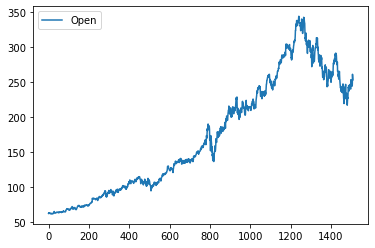

In [8]:
#Plot open column information
opn.plot()

In [9]:
import matplotlib.pyplot as plt


In [10]:
ds = opn.values
ds

array([[ 62.950001],
       [ 62.560001],
       [ 63.689999],
       ...,
       [261.690002],
       [257.130005],
       [253.720001]])

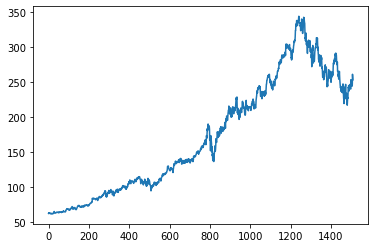

In [11]:
plt.plot(ds)

In [12]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [13]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

len(ds_scaled), len(ds)

(1510, 1510)

In [43]:
ds_scaled

array([[0.00269094],
       [0.00131007],
       [0.00531105],
       ...,
       [0.70636974],
       [0.69022416],
       [0.67815035]])

In [14]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

train_size,test_size

(1057, 453)

In [15]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [16]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [17]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [18]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='relu'))
model.summary()

2022-12-19 11:34:56.703226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
15/15 [==============================] - 6s 189ms/step - loss: 0.0219 - mean_absolute_error: 0.1091 - val_loss: 0.0713 - val_mean_absolute_error: 0.2591
Epoch 2/100
15/15 [==============================] - 2s 162ms/step - loss: 0.0028 - mean_absolute_error: 0.0405 - val_loss: 0.0065 - val_mean_absolute_error: 0.0677
Epoch 3/100
15/15 [==============================] - 2s 162ms/step - loss: 8.6143e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0025 - val_mean_absolute_error: 0.0411
Epoch 4/100
15/15 [==============================] - 2s 162ms/step - loss: 5.3451e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0026 - val_mean_absolute_error: 0.0423
Epoch 5/100
15/15 [==============================] - 3s 226ms/step - loss: 5.0435e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0025 - val_mean_absolute_error: 0.0408
Epoch 6/100
15/15 [==============================] - 3s 205ms/step - loss: 5.0610e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0026 - val_mean_absolute_error: 0

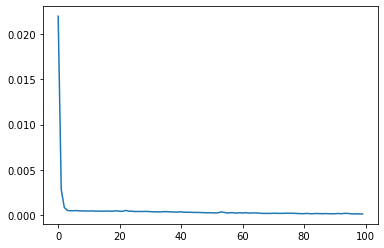

In [21]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [23]:
hist = pd.DataFrame(model.history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.021930,0.109066,0.071334,0.259144
1,0.002834,0.040469,0.006525,0.067672
2,0.000861,0.020177,0.002472,0.041143
3,0.000535,0.015960,0.002635,0.042329
4,0.000504,0.015015,0.002468,0.040775


<AxesSubplot:>

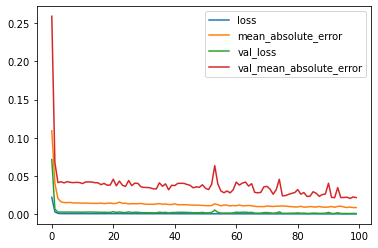

In [25]:
#Plot history 
hist.plot()

In [26]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


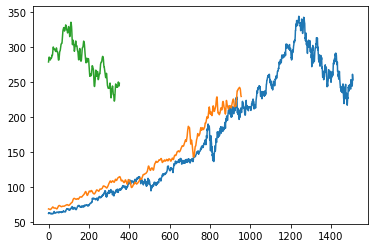

In [27]:

#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

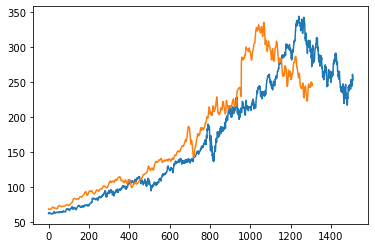

In [28]:
type(train_predict)

test = np.vstack((train_predict,test_predict))

#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [29]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.7179642010148

In [30]:

### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

282.2507970247551

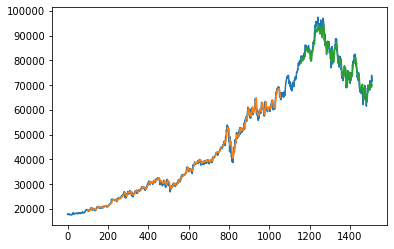

In [31]:
### Plotting 
# shift train predictions for plotting
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)
look_back=100
trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(ds)-1, :] = test_predict
# plot baseline and predictions
plt.plot(normalizer.inverse_transform(ds))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(ds_test)

453

In [33]:
#Getting the last 100 days records
fut_inp = ds_test[353:]


In [34]:




fut_inp = fut_inp.reshape(1,-1)

tmp_inp = list(fut_inp)

fut_inp.shape

(1, 100)

In [35]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [36]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6829358339309692], [0.6855472922325134], [0.6859057545661926], [0.6852735877037048], [0.6840935349464417], [0.682539701461792], [0.6807312965393066], [0.6787810325622559], [0.6767972707748413], [0.6748760938644409], [0.6730986833572388], [0.6715281009674072], [0.6702101826667786], [0.6691745519638062], [0.6684352159500122], [0.6679927706718445], [0.6678369045257568], [0.6679480671882629], [0.6682991981506348], [0.6688587069511414], [0.6695917248725891], [0.6704613566398621], [0.6714317202568054], [0.6724674105644226], [0.6735358238220215], [0.6746073365211487], [0.6756561994552612], [0.67666095495224], [0.6776041388511658], [0.6784728765487671]]


In [44]:
len(lst_output)

30

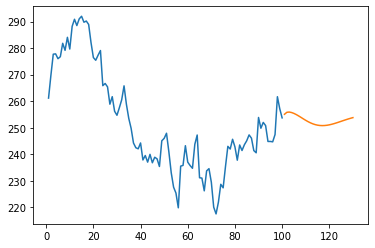

In [38]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1410:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [39]:
ds_new = ds_scaled.tolist()

len(ds_new)

1510

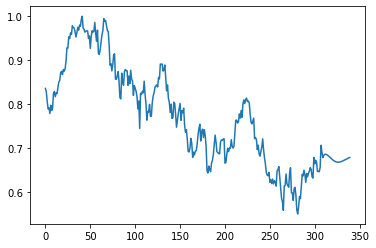

In [40]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [41]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

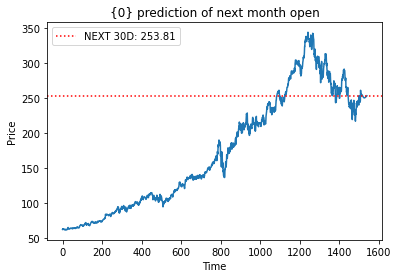

In [42]:


#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open")
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()